# Sales Outlier Detection and Removal Demo

This notebook demonstrates the simplified outlier detection and removal process using our new implementation.

Outliers are defined as:
- `qnt > 10`
- `|z-score| >= 10`

where z-scores are calculated within each (index_store + index_material) group.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Enable autoreload
%load_ext autoreload
%autoreload 2

# Add the parent directory to sys.path to import src modules
sys.path.append('..')

# Import our modules
from src.data.load import load_monthly_data
from src.outliers.detect import detect_outliers
from src.outliers.remove import save_outliers, clean_all_files
from src.config import DATA_DIR, OUTPUT_DIR

# Configure plot settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")

## 1. Load Sales Data

First, we'll load the sales data for the specified months.

In [2]:
# Load data for a few months to save memory
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
year = 2023

df = load_monthly_data(
    data_path=DATA_DIR,
    months=months,
    year=year
)

print(f"Loaded {len(df):,} records")
df.head()

2025-04-24 00:22:11,160 - src.data.load - INFO - Found 12 data files out of 12 expected files
2025-04-24 00:22:11,161 - src.data.load - INFO - Processing batch 1: ['202301.csv', '202302.csv']
2025-04-24 00:22:13,337 - src.data.load - INFO - Loaded 202301.csv with 2367733 rows
2025-04-24 00:22:15,330 - src.data.load - INFO - Loaded 202302.csv with 2104826 rows
Loading files: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]
2025-04-24 00:22:15,468 - src.data.load - INFO - Processing batch 2: ['202303.csv', '202304.csv']
2025-04-24 00:22:17,655 - src.data.load - INFO - Loaded 202303.csv with 2390433 rows
2025-04-24 00:22:19,963 - src.data.load - INFO - Loaded 202304.csv with 2469770 rows
Loading files: 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]
2025-04-24 00:22:20,233 - src.data.load - INFO - Processing batch 3: ['202305.csv', '202306.csv']
2025-04-24 00:22:22,860 - src.data.load - INFO - Loaded 202305.csv with 2802053 rows
2025-04-24 00:22:25,461 - src.data.load - INFO - Loaded 202306.cs

Loaded 39,321,003 records


,qnt,geolocal_type,format_merch,calday,index_material,index_store,source_month
0,0.0,season,S,2023-01-11,481,41,01
1,2.0,traffic,H,2023-01-11,2090,10,01
2,11.0,traffic,H,2023-01-11,1479,14,01
3,0.0,season,S,2023-01-11,341,45,01
4,0.0,mixed,H,2023-01-11,1933,2,01


## 2. Detect Outliers

Now we'll detect outliers based on our criteria:
- `qnt > 10`
- `|z-score| >= 10`

In [3]:
# Detect outliers
outliers = detect_outliers(df)

print(f"Found {len(outliers):,} outliers ({len(outliers)/len(df)*100:.3f}% of total records)")

# Display outliers
if not outliers.empty:
    display_cols = ['index_store', 'index_material', 'qnt', 'zscore', 'calday', 'source_month']
    display_cols = [col for col in display_cols if col in outliers.columns]
    outliers[display_cols].sort_values(by='zscore', ascending=False).head(10)

2025-04-24 00:22:50,309 - src.outliers.detect - INFO - Starting outlier detection with thresholds: qnt > 10, |zscore| >= 10
2025-04-24 00:22:50,310 - src.outliers.detect - INFO - Calculating z-scores by store-product groups...
C:\Users\dmbor\Notebooks\Diploma\final_pipeline\notebooks\..\src\outliers\detect.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df['zscore'].fillna(0, inplace=True)
2025-04-24 00:23:16,211 - src.outliers.detect - INFO - Z-score calculation complete
2025-04-24 00:23:16,357 - src.outliers.dete

Found 8,377 outliers (0.021% of total records)


## 3. Visualize Top Outliers

Let's visualize some of the most extreme outliers.

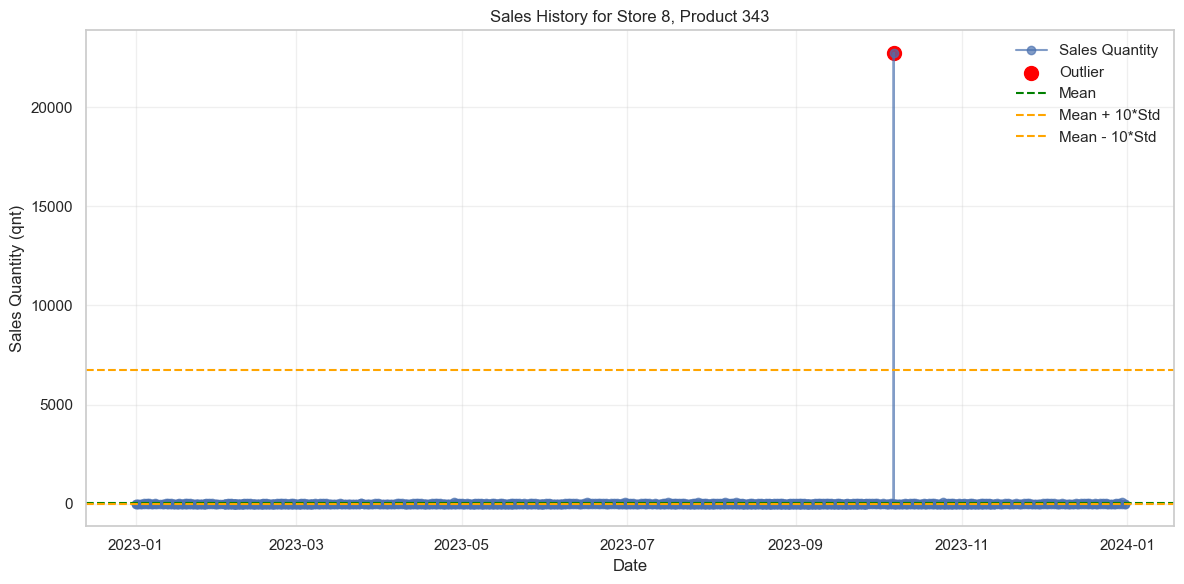


Sales stats for Store 8, Product 343:
Mean: 25.34, Std: 669.64
Outlier value: 22740.0, Z-score: 33.92


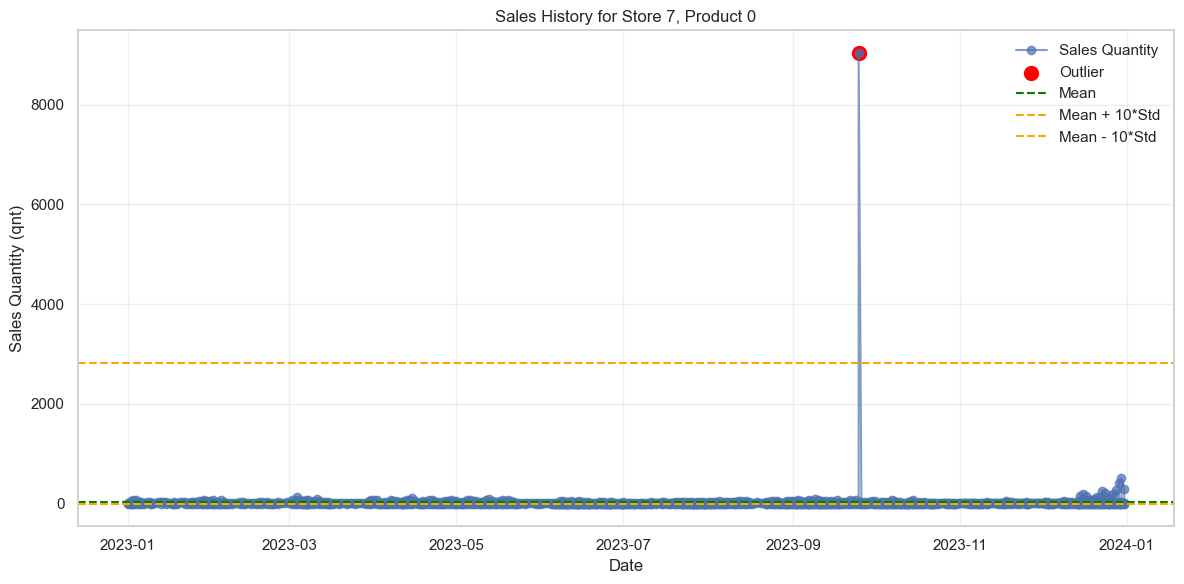


Sales stats for Store 7, Product 0:
Mean: 25.35, Std: 279.13
Outlier value: 9037.0, Z-score: 32.29


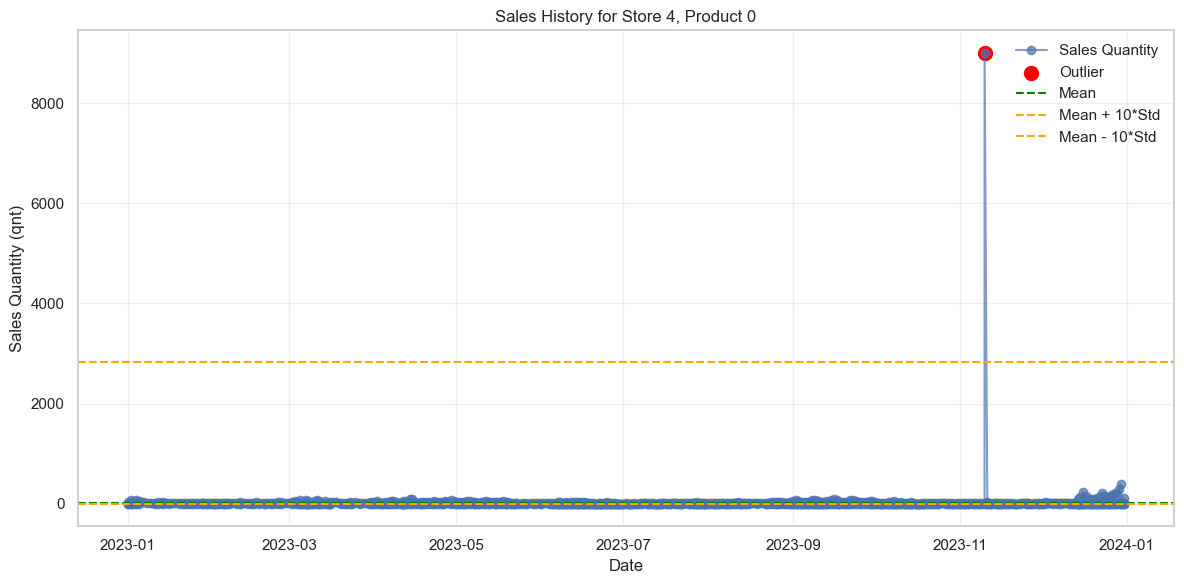


Sales stats for Store 4, Product 0:
Mean: 21.42, Std: 280.55
Outlier value: 9001.0, Z-score: 32.01


In [4]:
def plot_outlier(outlier_row, df):
    """Plot the sales history for a store-product group highlighting the outlier."""
    store = outlier_row['index_store']
    product = outlier_row['index_material']
    
    # Get all data for this store-product combination
    group_mask = (df['index_store'] == store) & (df['index_material'] == product)
    group_df = df[group_mask].sort_values('calday')
    
    # Calculate group stats
    mean = group_df['qnt'].mean()
    std = group_df['qnt'].std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(group_df['calday'], group_df['qnt'], 'o-', label='Sales Quantity', alpha=0.7)
    
    # Highlight the outlier
    plt.scatter([outlier_row['calday']], [outlier_row['qnt']], color='red', s=100, label='Outlier')
    
    # Add reference lines
    plt.axhline(y=mean, color='green', linestyle='--', label='Mean')
    
    if std > 0:
        plt.axhline(y=mean + 10*std, color='orange', linestyle='--', label='Mean + 10*Std')
        plt.axhline(y=max(0, mean - 10*std), color='orange', linestyle='--', label='Mean - 10*Std')
    
    plt.title(f'Sales History for Store {store}, Product {product}')
    plt.xlabel('Date')
    plt.ylabel('Sales Quantity (qnt)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nSales stats for Store {store}, Product {product}:")
    print(f"Mean: {mean:.2f}, Std: {std:.2f}")
    print(f"Outlier value: {outlier_row['qnt']}, Z-score: {outlier_row['zscore']:.2f}")

# Plot top 3 outliers by z-score
if not outliers.empty and len(outliers) >= 3:
    top_outliers = outliers.nlargest(3, 'zscore')
    for idx, row in top_outliers.iterrows():
        plot_outlier(row, df)

## 4. Save Outliers and Clean Data Files

In [5]:
# Save outliers to CSV
if not outliers.empty:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    outliers_path = os.path.join(OUTPUT_DIR, 'outliers.csv')
    save_outliers(outliers, outliers_path)

2025-04-24 00:23:17,523 - src.outliers.remove - INFO - Saved 8377 outliers to ../data/processed\outliers.csv


In [6]:
# Display outlier information and clean data files
if not outliers.empty:
    print("Sample of outliers to be removed:")
    display_cols = ['index_store', 'index_material', 'calday', 'source_month', 'qnt', 'zscore']
    display_cols = [col for col in display_cols if col in outliers.columns]
    display(outliers[display_cols].head())
    
    # Clean data files by removing outliers
    result = clean_all_files(
        data_dir=DATA_DIR,
        outliers=outliers,
        months=months,
        year=year,
        output_dir=OUTPUT_DIR
    )
    
    # Show summary of removed outliers
    print("\nOutlier Removal Summary:")
    for file, count in result.items():
        print(f"{file}: {count} outliers removed")

Sample of outliers to be removed:


,index_store,index_material,calday,source_month,qnt,zscore
459,12,1913,2023-01-14,01,15.0,11.578881
3108,64,1682,2023-01-13,01,25.0,10.872830
4189,49,619,2023-01-31,01,23.0,10.472999
13020,43,1493,2023-01-18,01,23.0,10.738276
20764,26,1445,2023-01-18,01,41.0,11.629663


2025-04-24 00:23:17,546 - src.outliers.remove - INFO - Found 12 data files to clean
2025-04-24 00:23:17,548 - src.outliers.remove - INFO - Processing 202301.csv...
Processing 202301.csv: 24it [01:06,  2.78s/it]
2025-04-24 00:24:24,310 - src.outliers.remove - INFO - Removed 1260 outliers from 202301.csv
2025-04-24 00:24:24,310 - src.outliers.remove - INFO - Saved cleaned file to ../data/processed\202301_clean.csv
2025-04-24 00:24:24,327 - src.outliers.remove - INFO - Processing 202302.csv...
Processing 202302.csv: 22it [01:00,  2.73s/it]
2025-04-24 00:25:24,385 - src.outliers.remove - INFO - Removed 862 outliers from 202302.csv
2025-04-24 00:25:24,387 - src.outliers.remove - INFO - Saved cleaned file to ../data/processed\202302_clean.csv
2025-04-24 00:25:24,389 - src.outliers.remove - INFO - Processing 202303.csv...
Processing 202303.csv: 24it [01:08,  2.86s/it]
2025-04-24 00:26:33,040 - src.outliers.remove - INFO - Removed 1153 outliers from 202303.csv
2025-04-24 00:26:33,040 - src.out


Outlier Removal Summary:
202301.csv: 1260 outliers removed
202302.csv: 862 outliers removed
202303.csv: 1153 outliers removed
202304.csv: 1128 outliers removed
202305.csv: 1517 outliers removed
202306.csv: 1908 outliers removed
202307.csv: 1617 outliers removed
202308.csv: 2059 outliers removed
202309.csv: 1718 outliers removed
202310.csv: 1695 outliers removed
202311.csv: 1653 outliers removed
202312.csv: 4451 outliers removed
